In [1]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [46]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import string
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import time
import math
def findFiles(path): return glob.glob(path)

<h2>Choose dataset

In [47]:
#all datapoints
pathToRep = 'dataset/rep/'
pathToExt = 'dataset/rep+extra/'

print(findFiles(pathToRep + 'training/*.txt'))
print(findFiles(pathToRep + 'validation/*.txt'))
print(findFiles(pathToExt + 'training/*.txt'))

['dataset/rep/training\\positive.txt', 'dataset/rep/training\\negative.txt']
['dataset/rep/validation\\negative.txt', 'dataset/rep/validation\\positive.txt']
['dataset/rep+extra/training\\positive.txt', 'dataset/rep+extra/training\\negative.txt']


In [49]:
all_letters = string.ascii_letters + " .,;'"
# n_letters = 200
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def clean(s):
    return s.replace('"', '').replace("'", "").replace(' ', '')

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
category_lines_val = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [clean(line) for line in lines]

for filename in findFiles(pathToExt + 'training/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

for filename in findFiles(pathToRep + 'validation/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    # all_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines

n_categories = len(all_categories)
print(len(all_letters))
print(all_categories)
print(random.randint(0, len(category_lines['positive'])-1))
print(category_lines['positive'][random.randint(0, len(category_lines['positive'])-1)])
print(category_lines_val['positive'][random.randint(0, len(category_lines_val['positive'])-1)])

57
['positive', 'negative']
11
jackson.core.JsonParser.setFeatureMask(int)jackson.core.JsonParser.overrideStdFeatures(int,int)
action.get.GetResponse.exists()action.get.GetResponse.isExists()


In [50]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [51]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# print(categoryFromOutput(output))

In [52]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomValidationExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_val[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    category, line, category_tensor, line_tensor = randomValidationExample()
    print('category val =', category, '/ line =', line)

category = negative / line = node.NodeBuilder.settings()index.IndexSettings()
category val = positive / line = angel.ml.core.conf.MLConf.ML_REG_L2()angel.ml.core.conf.AngelMLConf.ML_REG_L2()
category = positive / line = angel.ml.core.conf.MLConf.ML_MODEL_CLASS_NAME()angel.ml.core.conf.AngelMLConf.ML_MODEL_CLASS_NAME()
category val = positive / line = angel.ml.core.conf.MLConf.ML_REG_L2()angel.ml.core.conf.AngelMLConf.ML_REG_L2()
category = positive / line = DBMaker.newMemoryDB()DBMaker.memoryDB()
category val = positive / line = action.admin.indices.exists.indices.IndicesExistsResponse.exists()action.admin.indices.exists.indices.IndicesExistsResponse.isExists()
category = positive / line = action.index.IndexResponse.getId()action.DocWriteResponse.getId()
category val = positive / line = jedis.Jedis.select(int)jedis.BinaryJedis.select(int)
category = positive / line = angel.ml.core.conf.MLConf.ML_FEATURE_INDEX_RANGE()angel.ml.core.conf.AngelMLConf.ML_FEATURE_INDEX_RANGE()
category val =

In [53]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# n_hidden = 128


In [54]:
n_hidden = n_letters
rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()

In [55]:
def train(category_tensor, line_tensor, learning_rate):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [56]:
n_iters = 25000
print_every = 500
plot_every = 200

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

rate = 0.002

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # if iter < n_iters/10:
    #     rate = 0.005
    # elif iter > 5 * n_iters / 10:
    #     rate = 0.001
    # else:
    #     rate = 0.002
    output, loss = train(category_tensor, line_tensor, rate)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.7f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 2% (0m 6s) 0.7051370 catalina.deploy.FilterMap.addURLPattern(String)tomcat.util.descriptor.web.FilterMap.addURLPattern(String) / negative ✗ (positive)
1000 4% (0m 12s) 0.7349572 beans.factory.support.AbstractBeanDefinitionReader.getBeanFactory()beans.factory.support.AbstractBeanDefinitionReader.getRegistry() / negative ✗ (positive)
1500 6% (0m 17s) 0.7630902 jackson.core.JsonFactory.disable(Feature)jackson.core.TSFBuilder.configure(StreamWriteFeature,boolean) / positive ✗ (negative)
2000 8% (0m 23s) 0.7231376 action.delete.DeleteResponse.isNotFound()action.delete.DeleteRequest.routing() / positive ✗ (negative)
2500 10% (0m 29s) 0.6839524 dockerjava.api.model.HostConfig.isPublishAllPorts()dockerjava.api.model.HostConfig.getPublishAllPorts() / positive ✓
3000 12% (0m 35s) 0.6992069 sshd.SshServer.stop()sshd.server.SshServer.toString() / positive ✗ (negative)
3500 14% (0m 42s) 0.5867240 Matchers.startsWith(String)ArgumentMatchers.endsWith() / negative ✓
4000 16% (0m 48s) 0.8263856 act

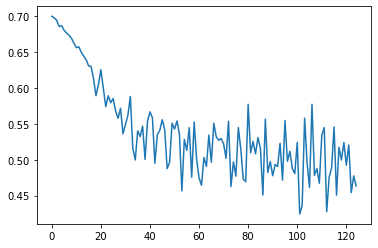

In [57]:
plt.figure()
plt.plot(all_losses)

In [64]:
n_confusion = 500

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
precision = {
    'positive': {
        'tp': 0,
        'total': 0
    },
    'negative': {
        'tp': 0,
        'total': 0
    }
}

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomValidationExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    # correct = '✓' if guess == category else '✗ (%s)' % category
    # print(line, guess, correct)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    precision[category]['total'] += 1
    if category is guess:
        precision[category]['tp'] += 1

print(precision)
print(confusion)

yp = precision['positive']['tp']/precision['positive']['total']
yr = float(confusion[0][0]/sum(confusion[0]))
print('(Yes) Precision:', yp)
# print('No precision:', precision['no']['tp']/precision['no']['total'])
print('(Yes) Recall:', yr)
print('(Yes) F1:', 2 * (yp * yr) / (yp + yr))

np = precision['negative']['tp']/precision['negative']['total']
nr = float(confusion[1][1]/sum(confusion[1]))
print('(No) Precision:', np)
# print('No precision:', precision['no']['tp']/precision['no']['total'])
print('(No) Recall:', nr)
print('(No) F1:', 2 * (np * nr) / (np + nr))

{'positive': {'tp': 147, 'total': 247}, 'negative': {'tp': 210, 'total': 253}}
tensor([[147., 100.],
        [ 43., 210.]])
(Yes) Precision: 0.5951417004048583
(Yes) Recall: 0.5951417088508606
(Yes) F1: 0.5951417046278594
(No) Precision: 0.8300395256916996
(No) Recall: 0.8300395011901855
(No) F1: 0.8300395134409423


C:\Users\mgwei\AppData\Local\Temp/ipykernel_18788/2806226085.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\mgwei\AppData\Local\Temp/ipykernel_18788/2806226085.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


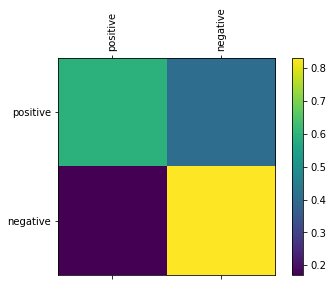

In [65]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()